# Goal of this notebook: Calculate results pertaining to MDPs

In [1]:
%matplotlib inline

In [2]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as plticker
import networkx as nx
import random

In [3]:
class MDP():
    '''Representation of a Markov Decision Process
    An MDP is defined by:
    states: a collection of nodes, with edges connecting only to actions, associated with rewards
    actions: a collection of nodes, with edges connecting only to states,
        weighted by probability of results'''
    def __init__(self, states, discount=0.5):
        self.states = set(states)
        self.utilities = {s:s.reward for s in self.states}
        self.discount = discount
        
    @property
    def graph(self):
        g = nx.DiGraph()
        for state in self.states:
            g.add_node(state, color='blue')
        for state in self.states:
            for action in state.actions:
                g.add_node(action, color='red')
                for tt in action.transitions:
                    g.add_edge(action, tt.result)
        return g
    
    def update_utilities(self):
        new_utilities = {}
        for state in self.states:
            if not state.terminal_p:
                action_values = []
                for action in state.actions:
                    action_value = 0
                    for tt in action.transitions:
                        if not tt.result.terminal_p:
                            transition_value = tt.weight * (tt.result.reward + self.utilities[tt.result])
                        else:
                            transition_value = tt.weight * (self.utilities[tt.result])
                        action_value += transition_value
                    action_values.append(action_value)
                new_utilities[state] = max(action_values)
            else:
                new_utilities[state] = self.utilities[state]
        self.utilities = new_utilities
        
    def view_graph(self):
        labels = {}
        grid_graph = self.graph
        pos=nx.graphviz_layout(grid_graph)

        for state in self.states:
            labels[state] = state.name
            for action in state.actions:
                nx.draw_networkx_nodes(grid_graph, pos, nodelist=[action], node_color='r')
                nx.draw_networkx_edges(grid_graph, pos, edgelist=[(state, action)], width=1, color='r')
                for tt in action.transitions:
                    nx.draw_networkx_edges(grid_graph, pos, edgelist=[(action, tt.result)], width=3*tt.weight)

        nx.draw_networkx_nodes(grid_graph, pos, nodelist=self.states, node_color='b', node_size=1000)

        nx.draw_networkx_labels(grid_graph, pos, labels, font_size=10, font_color='white', font_weight='bold')

        fig = plt.gcf()
        fig.set_size_inches(20,10)
        
class Action():
    def __init__(self, name, transitions):
        self.name = name
        self.transitions = set(transitions)
        
    def check_unitarity(self):
        assert sum([tt.weight for tt in transitions]) == 1.0
        
class Transition():
    def __init__(self, weight, result):
        self.weight = weight
        self.result = result
        
class State():
    def __init__(self, name, actions, reward, terminal_p):
        self.name = name
        self.actions = actions
        self.reward = reward
        self.terminal_p = terminal_p

In [4]:
class Square():
    def __init__(self, coords, reward, terminal_p):
        self.coords = coords
        self.reward = reward
        self.terminal_p = terminal_p

In [5]:
class Grid():
    def __init__(self, size, reward_default, gaps=[], terminals={}):
        self.size = size # pair of integers
        self.gaps = set(gaps) # list of pairs of integers
        self.terminals = terminals #dict, keys are pairs of integers and values are rewards
        self.reward_default = reward_default
        
        exes = range(1,size[0]+1)
        wyes = range(1,size[1]+1)
        
        coords = {(xx, yy) for xx in exes for yy in wyes}
        coords = coords - self.gaps
        self.squares = []
        for cc in coords:
            if cc in terminals:
                this_reward = terminals[cc]
                this_terminal_p = True
            else:
                this_reward = reward_default
                this_terminal_p = False
            this_square = Square(cc, this_reward, this_terminal_p)
            self.squares.append(this_square)
            
    def isBoundary(self, coords):
        if coords[0] == 0 or coords[1] == 0:
            return True
        elif coords[0] == self.size[0]+1 or coords[1] == self.size[1]+1:
            return True
        else:
            return False
        
    def view(self):
        xmax = self.size[0]+2
        ymax = self.size[1]+2
        
        rewards = [sq.reward for sq in self.squares]
        image = np.ones((ymax, xmax))*(min(rewards)-1)
        
        fig=plt.figure(figsize=(xmax, ymax))
        ax=fig.add_subplot(111)
        fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
        # Set the gridding interval: here we use the major tick interval
        myInterval=1.0
        loc = plticker.MultipleLocator(base=myInterval)
        ax.xaxis.set_major_locator(loc)
        ax.yaxis.set_major_locator(loc)

        # Add the grid
        ax.grid(which='major', axis='both', linestyle='-')
        
        for sq in self.squares:
            xx, yy = sq.coords

            image[yy, xx] = sq.reward
            y=myInterval/2+yy*myInterval
            x=myInterval/2.+xx*myInterval
            ax.text(x,y,'%d,%d\n%2.2f'%(xx, yy, sq.reward),color='black',ha='center',va='center')

        # Add the image

        ax.imshow(np.flipud(image), interpolation='none', cmap=cm.RdBu, extent=[0, xmax, 0, ymax], vmin=min(rewards)-1, vmax=max(rewards)+1)
        ax.get_xaxis().set_ticklabels([])
        ax.get_yaxis().set_ticklabels([])

##testing 

In [6]:
gg = Grid((4, 3), -.05, gaps=[(2, 2)], terminals={(4, 3):1, (4, 2):-1})

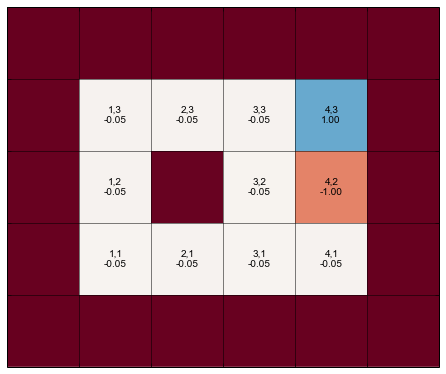

In [7]:
gg.view()

##convert Grid into MDP 

In [8]:
def square2blankstate(sq):
    name = "%d, %d"%sq.coords
    actions = []
    reward = sq.reward
    terminal_p = sq.terminal_p
    return State(name, actions, reward, terminal_p)

def adjacent(sq_pair):
    sq1, sq2 = sq_pair
    x1, y1 = sq1.coords
    x2, y2 = sq2.coords
    
    if x1==x2 and y1==y2:
        return False
    
    if abs(x1 - x2) <= 1  and y1==y2:
        return True
    
    if abs(y1-y2) <= 1 and x1==x2:
        return True
    
    return False
    
def get_neighbors(sq, grid):
    neighbors = filter(lambda ss: adjacent((ss, sq)), grid.squares)
    return neighbors
            
#for each neighbor, check if left turn and right turn neighbors exist, and create transitions appropriately
#use transitions to build the action 'attempt to move to neighbor'
#and then build the state

In [9]:
left_turn = {(1, 0):(0, 1),
          (0, 1):(-1,0),
          (-1,0):(0,-1),
          (0,-1):(1,0)}

right_turn = {(1,0):(0,-1),
             (0,-1):(-1,0),
             (-1,0):(0,1),
             (0,1):(1,0)}


PP_LHT_ERROR = 0.1
PP_RHT_ERROR = 0.1
PP_SUCCESS = 1 - PP_LHT_ERROR - PP_RHT_ERROR

#allpairs = [(sq1, sq2) for sq1 in gg.squares for sq2 in gg.squares]
#neighbor_pairs = filter(adjacent, allpairs)

def get_destinations(pair, grid):
    '''given a pair of squares (start) and (destination), construct a tuple
    (destination, righthand, lefthand) of squares'''
    
    start, destination = pair
    
    start_nbrs = get_neighbors(start, grid)
    try:
        assert destination in start_nbrs
    except AssertionError:
        print 'Start'
        print start.coords
        print 'Start Neighbors:'
        for sq in start_nbrs:
            print sq.coords
        print 'Dest:'
        print destination.coords
        raise AssertionError
    
    x_start, y_start = start.coords
    x_dest, y_dest = destination.coords
    
    motion_vector = (x_dest - x_start, y_dest - y_start)
    x_rht, y_rht = right_turn[motion_vector]
    x_lht, y_lht = left_turn[motion_vector]
    
    rht_coords = (x_rht+x_start, y_rht+y_start)
    lht_coords = (x_lht+x_start, y_lht+y_start)
    
    try:
        rht_result = filter(lambda sq: sq.coords==rht_coords, start_nbrs)[0]
    except IndexError:
        rht_result = None
        
    try:
        lht_result = filter(lambda sq: sq.coords==lht_coords, start_nbrs)[0]
    except IndexError:
        lht_result = None
    
    return (destination, rht_result, lht_result)

#dests = {pair : get_destinations(pair) for pair in neighbor_pairs}

def get_transition_tuples(start, destinations):
    target, righthand, lefthand = destinations
    if righthand is None:
        righthand = start
    if lefthand is None:
        lefthand = start
        
    target_tuple = (PP_SUCCESS, target)
    rht_tuple = (PP_RHT_ERROR, righthand)
    lht_tuple = (PP_LHT_ERROR, lefthand)
    
    return (target_tuple, rht_tuple, lht_tuple)

#transitions = {pair:get_transition_tuples(pair[0], dests[pair]) for pair in neighbor_pairs}


def get_action_name(pair):
    start, dest = pair
    name = "%s to %s"%(start.coords, dest.coords)
    return name

#actions = {pair:get_action_name(pair) for pair in neighbor_pairs}

##Construct MDP Agent 

In [10]:
def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

class MDP_Agent():
    def __init__(self, mdp, initial_state):
        self.problem = mdp
        self.state = initial_state
        self.trove = self.state.reward #accumulated reward
        
        self.policy = self.random_policy
        
        self.done=False
        
        self.think_steps = 50

        
    def take_step(self):
        if not self.done:
            next_action = self.policy()
            possible_results = [tt.result for tt in next_action.transitions]
            probs = [tt.weight for tt in next_action.transitions]
            result = np.random.choice(possible_results, p=probs)
            self.state = result
            self.trove += result.reward
            if self.state.terminal_p:
                self.done=True
                
    def consider_problem(self):
        for ii in range(self.think_steps):
            self.problem.update_utilities()
            
    def optimal_policy(self):
        available_actions = self.state.actions
        action_values = []
        for action in available_actions:
            action_value = 0
            for tt in action.transitions:
                transition_value = tt.weight * self.problem.utilities[tt.result]
                action_value += transition_value
            action_values.append(action_value)
        return available_actions[argmax(action_values)]
        
        
    
    def random_policy(self):
        action = random.choice(self.state.actions)
        return action
        
    def report(self):
        print 'State is %s'%self.state.name
        print 'Accumulated reward is %f'%self.trove
        print '-'*10
            
    def run(self, max_steps = 20):
        nsteps = 0
        while not self.done and nsteps < max_steps:
            nsteps+=1
            print 'Step #%d'%nsteps
            self.take_step()
            self.report()
        if self.done:
            print 'Done'

##Visualize value iteration 

In [11]:
class GridMDP(MDP):
    def __init__(self, gg, discount=0.5):
        self.grid = gg
        
        allpairs = [(sq1, sq2) for sq1 in gg.squares for sq2 in gg.squares]
        neighbor_pairs = filter(adjacent, allpairs)
        neighbor_pairs = filter(lambda pair: not pair[0].terminal_p, neighbor_pairs)
        dests = {pair : get_destinations(pair, gg) for pair in neighbor_pairs}
        transitions = {pair:get_transition_tuples(pair[0], dests[pair]) for pair in neighbor_pairs}
        actions = {pair:get_action_name(pair) for pair in neighbor_pairs}
        
        sqs2states = {sq:square2blankstate(sq) for sq in gg.squares}
        self.sqs2states = sqs2states
        pairs2transitions = {pair:[Transition(tt[0], sqs2states[tt[1]]) for tt in transitions[pair]] for pair in neighbor_pairs}
        pairs2actions = {pair:Action(actions[pair], pairs2transitions[pair]) for pair in neighbor_pairs}
        
        non_terminal_sqs = filter(lambda sq: not sq.terminal_p, gg.squares)
        
        sqs2pairs = {sq:[(sq, nbr) for nbr in get_neighbors(sq, gg)] for sq in non_terminal_sqs}
        sqs2actions = {sq:[pairs2actions[pp] for pp in sqs2pairs[sq]] for sq in non_terminal_sqs}
        states2actions = {sqs2states[sq]:sqs2actions[sq] for sq in non_terminal_sqs}

        for state, actionlist in states2actions.items():
            state.actions = actionlist
            
        self.states = sqs2states.values()
        
        self.utilities = {s:s.reward for s in self.states}
        self.discount = discount
        
    @property
    def start_state(self):
        return self.sqs2states[self.grid.squares[0]]
        
    def view(self):
        xmax = self.grid.size[0]+2
        ymax = self.grid.size[1]+2
        
        rewards = [self.utilities[self.sqs2states[sq]] for sq in self.grid.squares]
        image = np.ones((ymax, xmax))*(min(rewards)-1)
        
        fig=plt.figure(figsize=(xmax, ymax))
        ax=fig.add_subplot(111)
        fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
        # Set the gridding interval: here we use the major tick interval
        myInterval=1.0
        loc = plticker.MultipleLocator(base=myInterval)
        ax.xaxis.set_major_locator(loc)
        ax.yaxis.set_major_locator(loc)

        # Add the grid
        ax.grid(which='major', axis='both', linestyle='-')
        
        for sq in self.grid.squares:
            xx, yy = sq.coords

            image[yy, xx] = self.utilities[self.sqs2states[sq]]
            y=myInterval/2+yy*myInterval
            x=myInterval/2.+xx*myInterval
            ax.text(x,y,'%d,%d\n%2.2f'%(xx, yy, self.utilities[self.sqs2states[sq]]),color='black',ha='center',va='center')

        # Add the image

        ax.imshow(np.flipud(image), interpolation='none', cmap=cm.RdBu, extent=[0, xmax, 0, ymax], vmin=min(rewards)-1, vmax=max(rewards)+1)
        ax.get_xaxis().set_ticklabels([])
        ax.get_yaxis().set_ticklabels([])

In [12]:
gg2 = Grid((4, 4), -.05, gaps=[(2, 2)], terminals={(4, 3):1, (4, 2):-1})

ggmdp = GridMDP(gg2)

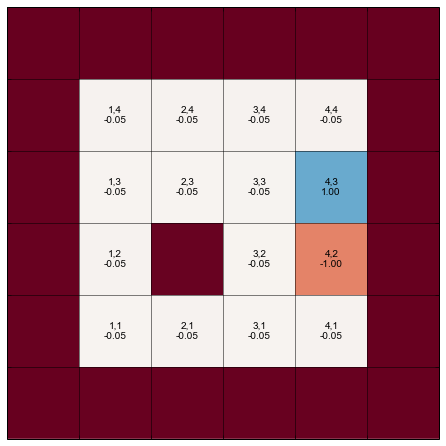

In [13]:
ggmdp.view()

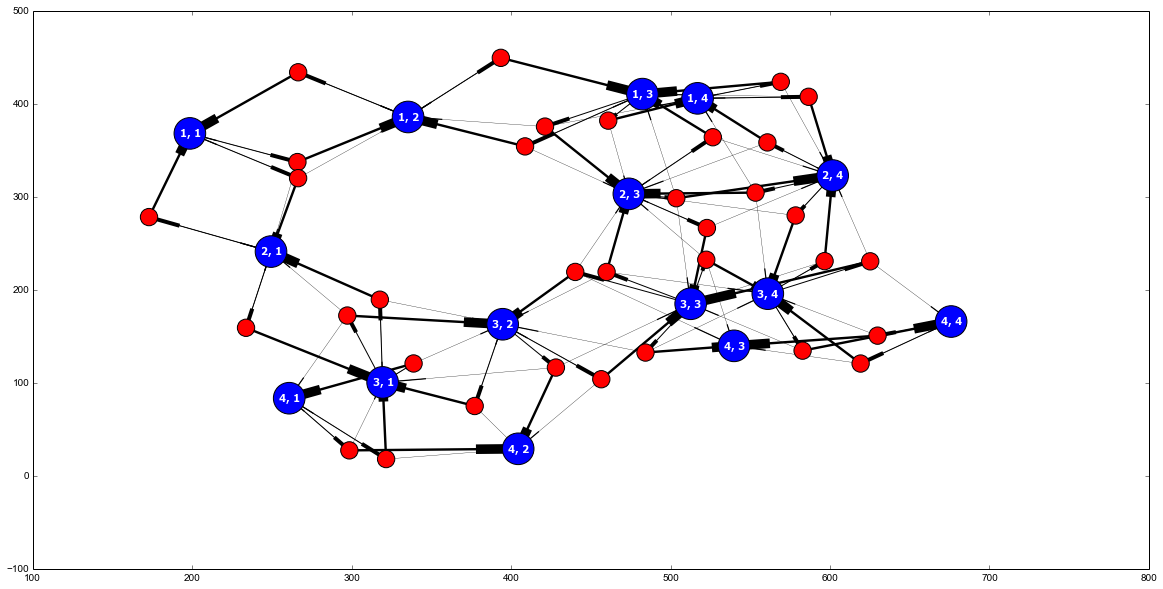

In [14]:
ggmdp.view_graph()

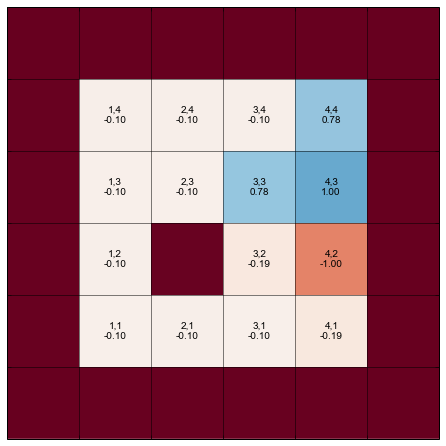

In [15]:
ggmdp.update_utilities()
#for state in ggmdp.states:
#    print state.name
#    print ggmdp.utilities[state]
ggmdp.view()

##Try Agent 

In [16]:
this_agent = MDP_Agent(ggmdp, ggmdp.start_state)

In [17]:
this_agent.report()

State is 1, 2
Accumulated reward is -0.050000
----------


In [18]:
this_agent.take_step()
this_agent.report()

State is 1, 3
Accumulated reward is -0.100000
----------


In [19]:
this_agent.run()

Step #1
State is 2, 3
Accumulated reward is -0.150000
----------
Step #2
State is 3, 3
Accumulated reward is -0.200000
----------
Step #3
State is 3, 2
Accumulated reward is -0.250000
----------
Step #4
State is 3, 2
Accumulated reward is -0.300000
----------
Step #5
State is 4, 2
Accumulated reward is -1.300000
----------
Done


In [20]:
this_agent = MDP_Agent(ggmdp, ggmdp.start_state)
this_agent.policy = this_agent.optimal_policy
this_agent.consider_problem()

In [21]:
this_agent.run()

Step #1
State is 1, 3
Accumulated reward is -0.100000
----------
Step #2
State is 2, 3
Accumulated reward is -0.150000
----------
Step #3
State is 2, 4
Accumulated reward is -0.200000
----------
Step #4
State is 3, 4
Accumulated reward is -0.250000
----------
Step #5
State is 3, 3
Accumulated reward is -0.300000
----------
Step #6
State is 4, 3
Accumulated reward is 0.700000
----------
Done


In [22]:
optimal_results = []

for ii in range(1000):
    this_agent = MDP_Agent(ggmdp, ggmdp.start_state)
    this_agent.policy = this_agent.optimal_policy
    this_agent.consider_problem()
    this_agent.run()
    optimal_results.append(this_agent.trove)
    clear_output()

In [23]:
#print optimal_results
print np.mean(optimal_results)
print np.std(optimal_results)

0.70315
0.203377917926


In [24]:
random_results = []

for ii in range(1000):
    this_agent = MDP_Agent(ggmdp, ggmdp.start_state)
    this_agent.policy = this_agent.random_policy
    this_agent.consider_problem()
    this_agent.run()
    random_results.append(this_agent.trove)
    clear_output()

In [25]:
#print random_results
print np.mean(random_results)
print np.std(random_results)

-0.843
0.76690351414


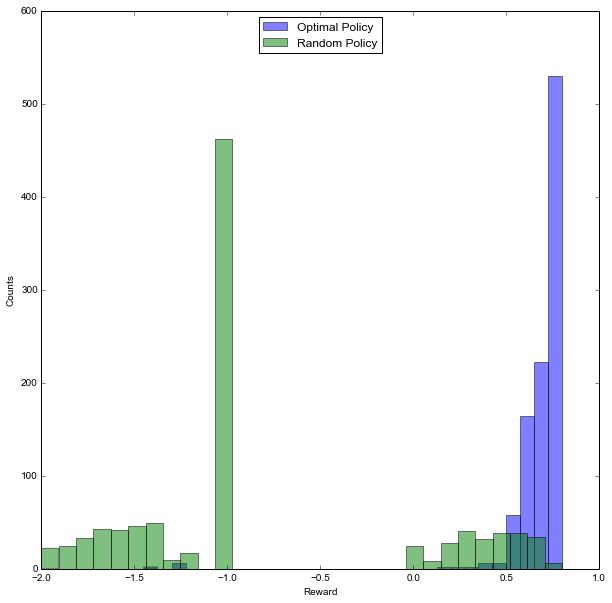

In [26]:
plt.figure(figsize=(10,10))
plt.hist(optimal_results, 30, label='Optimal Policy', alpha=0.5)
plt.hist(random_results, 30, label='Random Policy', alpha=0.5)
plt.legend(loc='upper center')
plt.xlabel('Reward')
plt.ylabel('Counts')

## this appears to work